In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [4]:
import pathlib
data_dir = ('/content/drive/MyDrive/Unzipped/archive/asl_alphabet_train/asl_alphabet_train')
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

36035


In [5]:
batch_size = 192
img_height = 200
img_width = 200

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 36035 files belonging to 24 classes.
Using 28828 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 36035 files belonging to 24 classes.
Using 7207 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [9]:
#Hot one code our labels
from sklearn.preprocessing import LabelBinarizer

label_binrizer = LabelBinarizer()
labels = label_binrizer.fit_transform(class_names)

In [ ]:
labels

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
#Import resnet101v2 and build it with other input and output layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#resnet101v2_model = Sequential()

#pretrained_model = tf.keras.applications.ResNet101V2(include_top=False,
                                                     #input_shape=(200,200,3),
                                                     #pooling='avg',
                                                     #weights='imagenet')
#for layer in pretrained_model.layers:
        #layer.trainable=False

#resnet101v2_model.add(pretrained_model)

base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(200, 200, 3),
    include_top=False)



94781440/94765736 [==============================] - 0s 0us/step


In [14]:
from keras.layers import Dense, Activation, Flatten


base_model.trainable = False

inputs = keras.Input(shape=(200, 200, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(24)(x)
model = keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 24)                49176     
                                                                 
Total params: 23,636,888
Trainable params: 49,176
Non-trainable params: 23,587,712
____________________________________________

In [16]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  batch_size=512
)

Epoch 1/10
151/151 [==============================] - 2050s 13s/step - loss: 0.8959 - accuracy: 0.7724 - val_loss: 0.2850 - val_accuracy: 0.9600
Epoch 2/10
151/151 [==============================] - 101s 672ms/step - loss: 0.2412 - accuracy: 0.9541 - val_loss: 0.1499 - val_accuracy: 0.9825
Epoch 3/10
151/151 [==============================] - 100s 665ms/step - loss: 0.1472 - accuracy: 0.9751 - val_loss: 0.1019 - val_accuracy: 0.9886
Epoch 4/10
151/151 [==============================] - 101s 667ms/step - loss: 0.1053 - accuracy: 0.9822 - val_loss: 0.0746 - val_accuracy: 0.9922
Epoch 5/10
151/151 [==============================] - 100s 666ms/step - loss: 0.0812 - accuracy: 0.9885 - val_loss: 0.0602 - val_accuracy: 0.9936
Epoch 6/10
151/151 [==============================] - 100s 666ms/step - loss: 0.0649 - accuracy: 0.9907 - val_loss: 0.0489 - val_accuracy: 0.9958
Epoch 7/10
151/151 [==============================] - 100s 665ms/step - loss: 0.0553 - accuracy: 0.9919 - val_loss: 0.0407 - 

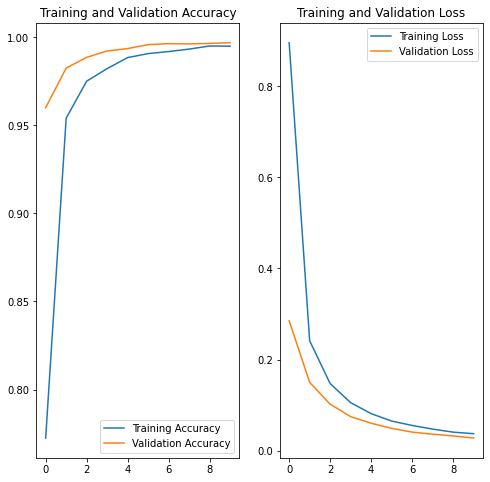

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
#Save the model
model.save("ResNet50.h5")
print("Model saved")

Model saved


In [49]:
import pathlib
test_dir = ('/content/drive/MyDrive/Unzipped/archive/asl_alphabet_test')
test_dir = pathlib.Path(test_dir)
test_count = len(list(test_dir.glob('*/*.jpg')))
print(test_count)

1


In [50]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width))

Found 1 files belonging to 1 classes.


In [51]:
from numpy import argmax
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions)
#print(score)

In [52]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to I with a 44.53 percent confidence.


In [28]:
from google.colab import files
uploaded = files.upload()

Saving A_test.jpg to A_test.jpg


In [29]:
#Loading the image and converting into Byte
from PIL import Image
from io import BytesIO
img_array= Image.open(BytesIO(uploaded["A_test.jpg"]))

In [40]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

# load the image
#img = load_img(img_array)
# convert to numpy array
data = img_to_array(img_array)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(brightness_range=[6.0,6.5],zoom_range=[0.5,1.0])

In [41]:
# prepare iterator
it = datagen.flow(samples, batch_size=1)

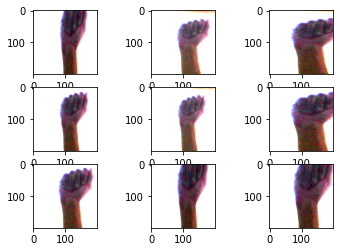

In [42]:
# generate samples and plot
from matplotlib import pyplot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [43]:
type(it)
predictions = model.predict(it)

score = tf.nn.softmax(predictions)

In [44]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to A with a 49.58 percent confidence.
